In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2
from cvaei.examples.two_moons import TwoMoons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [4]:
two_moons = TwoMoons()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = two_moons.prepare_data(100000)
observed_data = two_moons.observed_data()
two_moons.check_normalizer()

Normalization and denormalization process is consistent for both parameters and observed data.


In [7]:
train_theta_norm.shape , train_data_norm.shape

(torch.Size([1000, 2]), torch.Size([1000, 100]))

# Initialise the Model

In [5]:
ma2 = MovingAverage2()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = ma2.prepare_data(1000)
observed_data = ma2.observed_data()
print(ma2.check_normalizer())

# test = torch.tensor([0.6409, 0.8635], dtype = torch.float32)
# two_moons.simulator(test)

Normalization and denormalization process is consistent for both parameters and observed data.
None


In [6]:
print(hello)

NameError: name 'hello' is not defined

In [ ]:
two_moons.simulator(test)

tensor([[-0.7799,  0.2447]])

In [ ]:
two_moons.simulator(test)

tensor([[-0.7799,  0.2447]])

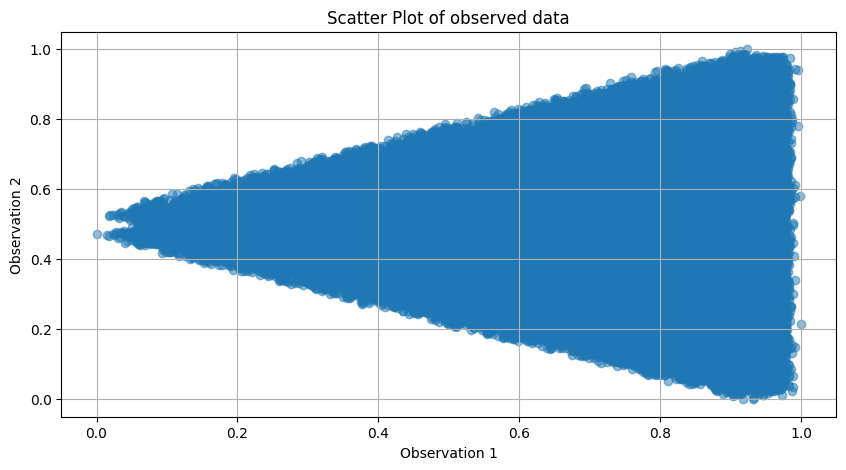

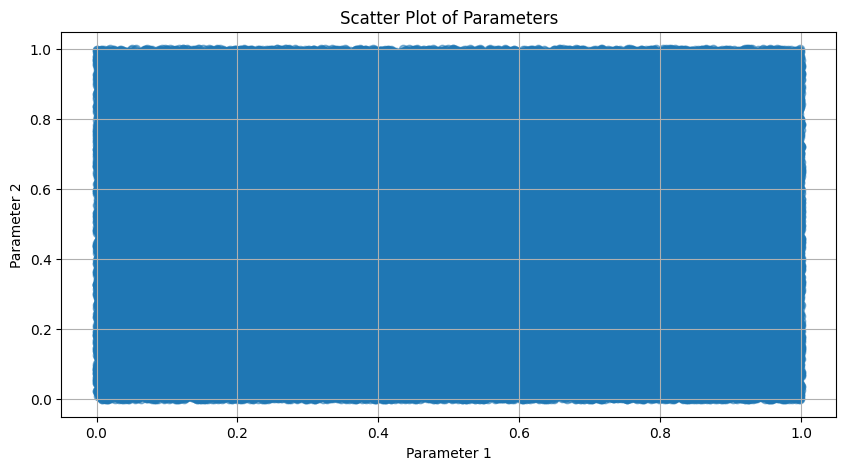

In [ ]:
two_moons.plot_observation(train_data_norm)
two_moons.plot_prior(train_theta_norm)

# Define the CVAE Network

In [ ]:
input_dim = 2
latent_dim = 20
conditional_dim = 2
encoder_hidden_dims = [100]
decoder_hidden_dims = [2048,2048,2048]
activation_fn = nn.LeakyReLU(0.1)

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)

print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=100, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=100, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=22, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): LeakyReLU(negative_slope=0.1)
    )
    (final_layer): Linear(in_features=2048, out_features=2, bias=True)
  )
)


In [ ]:
network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=4, 
                    device=device, theta_normalizer=theta_normalizer,
                      data_normalizer=data_normalizer, forward_model= two_moons.simulator)

Using CPU
Epoch 1/4, Beta: 0.0, Total Loss: 139376.3568, Recon Loss: 61380.3881, Misfit Loss: 77995.9647, KL Div: 35610.6180
Epoch 2/4, Beta: 0.1, Total Loss: 16908.9388, Recon Loss: 11523.5949, Misfit Loss: 3245.0227, KL Div: 21403.2117
Epoch 3/4, Beta: 0.2, Total Loss: 15424.1824, Recon Loss: 11796.8449, Misfit Loss: 2306.6898, KL Div: 6603.2383
Epoch 4/4, Beta: 0.3, Total Loss: 14366.3831, Recon Loss: 11768.5090, Misfit Loss: 2230.5627, KL Div: 1224.3713


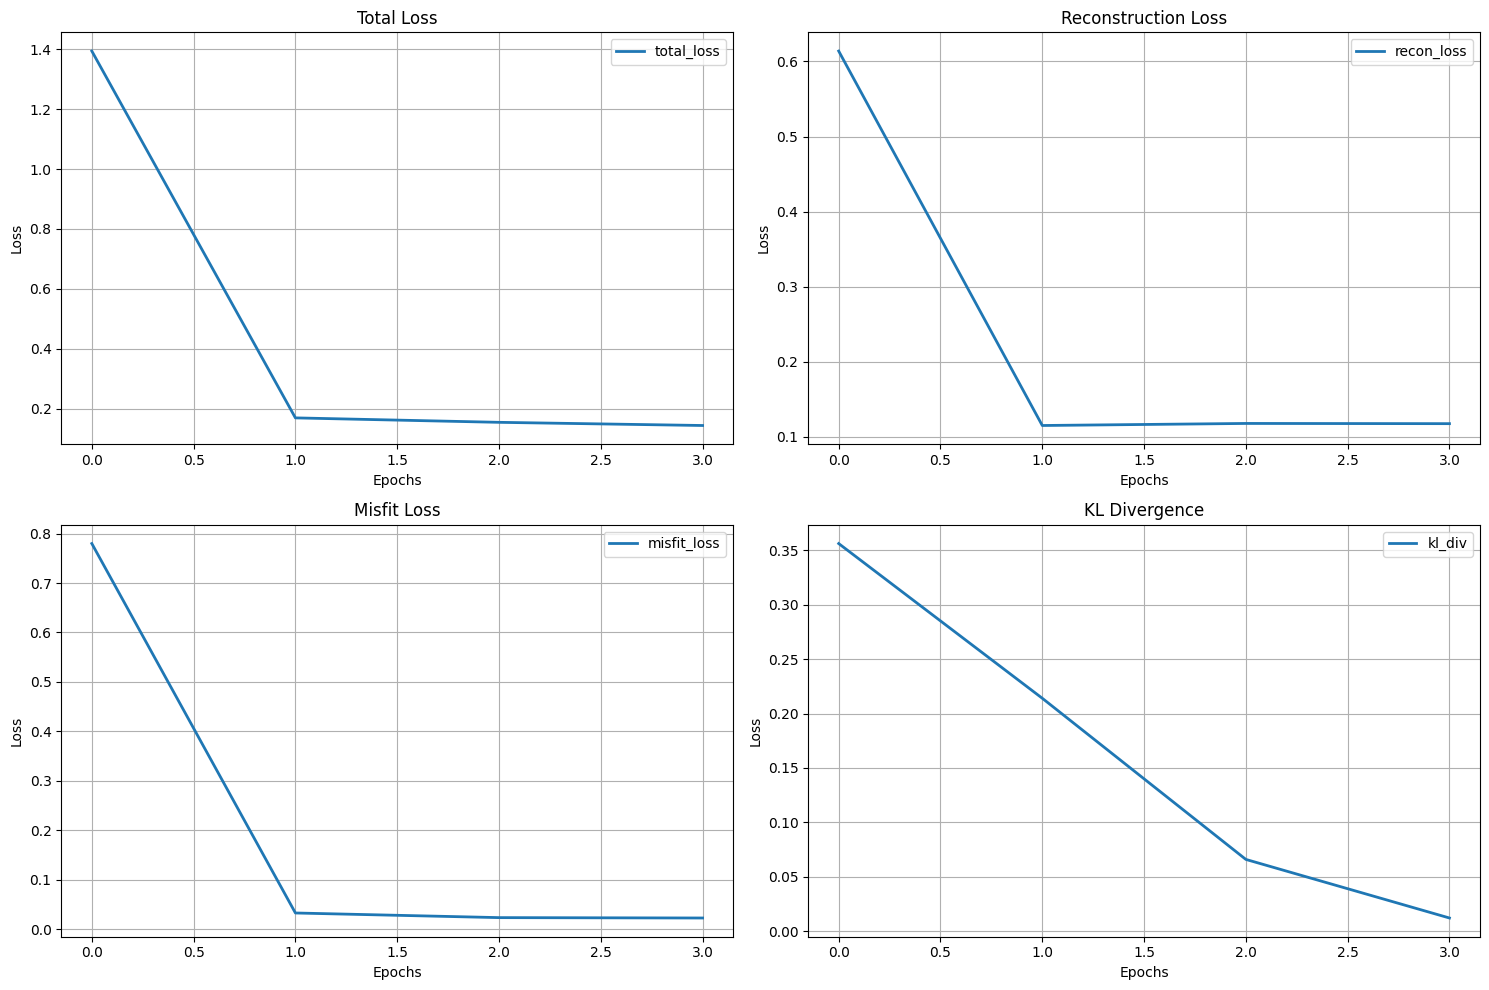

In [ ]:
network.plot_loss()

# Inference

In [ ]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


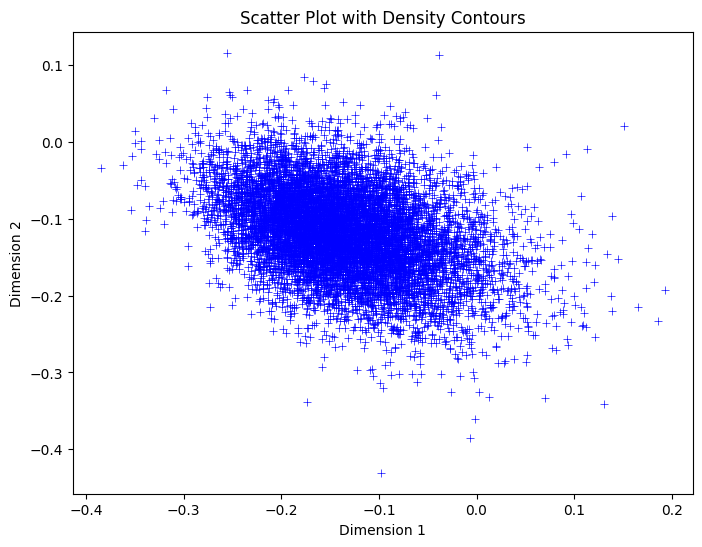

In [ ]:
two_moons.plot_posterior(post)

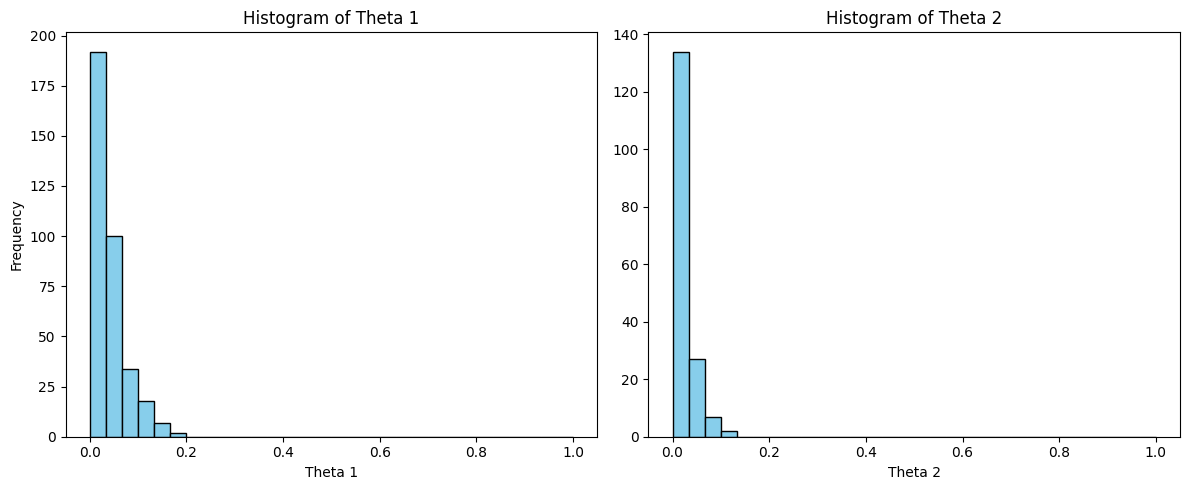

In [ ]:
two_moons.posterior_hist(post)

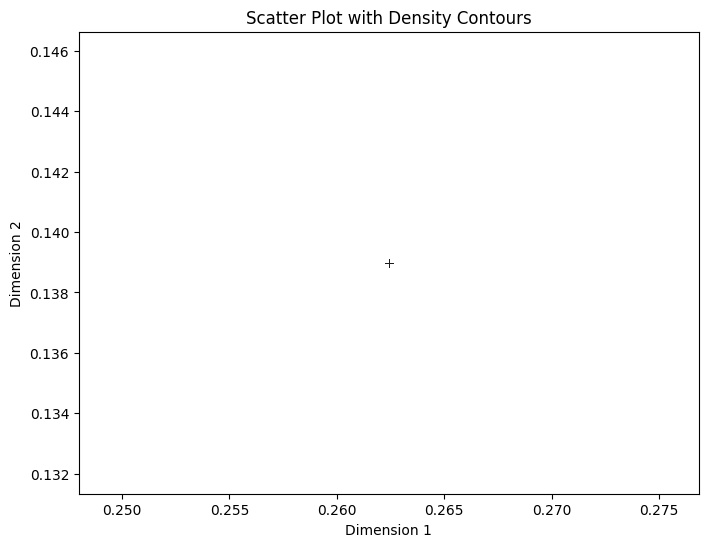

In [ ]:
two_moons.analytic_posterior()